# Simulation for Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [29]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
    if prt: print('n,k,cl',n,k,cl)
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
#     if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [30]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)

0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
def plot_avg_std_colors (N):
    max_gamma = 15
    gammas = np.linspace(0, max_gamma, num=100)
    z = [np.e**(-gamma) for gamma in gammas]
    y = [E_cols(N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N,zz,C)) for zz in z]
    f = plt.figure(figsize=(18, 5))
    plt.errorbar(gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
    plt.xlabel("Gamma (g)") 
    plt.ylabel("Std. num. colors")
    plt.title(str(N) + " total sites / colors")
#     plt.savefig("Expected_no_colors/avg_std_(" + str(N)+","+str(N)+")_vary_gamma_.png", format="png")
    plt.show()

In [ ]:
plot_avg_std_colors (9)

In [31]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/

import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind

# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def sample_config(config, eta, N, no_colors, sites, uf=None, cluster_constraints=None):
    
    if uf==None:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field
    if alpha==0:
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_cols,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)

        '''Sample a partition of the no. of clusters into k using Bell polynomials'''
        session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
        partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs],subs]")
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part+=([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field
    else:
        '''Randomly sample a color for each cluster'''
        for root in cluster_constraints:
            max_col = cluster_constraints[root]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            for site_str in uf.clusteronent(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites):
    '''Assign a color configuration chosen uniformly from the configurations clusteratible with eta'''
    # Brute force version
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [39]:
# Small experiment


N, no_cols = 3, 9
gamma = 1    # strength of preference for low no. of cols
J = 0      # strength of preference for bonds
alpha = 0  # strength of preference for colors (field)

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)

prt = True

for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

session.terminate()

lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[4 6 4]
 [4 3 8]
 [6 6 4]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
current no. cols (lambda): 4
assigned no. cols (eta_lambda): 5
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [7 8 9]]
n,k,cl 9 1 9
n,k,cl 9 2 9
n,k,cl 9 3 9
n,k,cl 9 4 9
n,k,cl 9 5 9
prob_k: [9, 18360, 1524600, 23496

 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [7 8 9]]
n,k,cl 9 1 9
n,k,cl 9 2 9
n,k,cl 9 3 9
n,k,cl 9 4 9
n,k,cl 9 5 9
n,k,cl 9 6 9
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080]
prob_k: [3.10164452e-08 6.32735482e-05 5.25418582e-03 8.09752538e-02
 3.62200122e-01 5.51507134e-01]
exact number of colors to use in configuration:
6
partition_dict {(5, 0, 0, 1): 126, (4, 1, 1, 0): 1260, (3, 3, 0, 0): 1260}
partition_p: [126, 1260, 1260]
partition_p: [0.047619047619047616, 0.47619047619047616, 0.47619047619047616]
chosen partition:
(4, 1, 1, 0)
chosen partition:
[1, 1, 1, 1, 2, 3]
colors for clusters:
[4 7 1 7 5 2 5 5 9]
config:
[[4 7 1]
 [7 5 2]
 [5 5 9]]

-------------------- iter 11 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 6
probabilitie

exact number of colors to use in configuration:
3
partition_dict {(2, 0, 0, 0, 0, 0, 1): 36, (1, 1, 0, 0, 0, 1, 0): 252, (1, 0, 1, 0, 1, 0, 0): 504, (1, 0, 0, 2, 0, 0, 0): 315, (0, 2, 0, 0, 1, 0, 0): 378, (0, 1, 1, 1, 0, 0, 0): 1260, (0, 0, 3, 0, 0, 0, 0): 280}
partition_p: [36, 252, 504, 315, 378, 1260, 280]
partition_p: [0.011900826446280991, 0.08330578512396694, 0.16661157024793388, 0.10413223140495868, 0.12495867768595041, 0.41652892561983473, 0.09256198347107437]
chosen partition:
(0, 1, 1, 1, 0, 0, 0)
chosen partition:
[2, 3, 4]
colors for clusters:
[4 4 4 1 8 8 4 1 1]
config:
[[4 4 4]
 [1 8 8]
 [4 1 1]]

-------------------- iter 18 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 3
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [

 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [7 8 9]]
n,k,cl 9 1 9
n,k,cl 9 2 9
n,k,cl 9 3 9
n,k,cl 9 4 9
n,k,cl 9 5 9
n,k,cl 9 6 9
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080]
prob_k: [3.10164452e-08 6.32735482e-05 5.25418582e-03 8.09752538e-02
 3.62200122e-01 5.51507134e-01]
exact number of colors to use in configuration:
6
partition_dict {(5, 0, 0, 1): 126, (4, 1, 1, 0): 1260, (3, 3, 0, 0): 1260}
partition_p: [126, 1260, 1260]
partition_p: [0.047619047619047616, 0.47619047619047616, 0.47619047619047616]
chosen partition:
(3, 3, 0, 0)
chosen partition:
[1, 1, 1, 2, 2, 2]
colors for clusters:
[5 1 2 7 5 4 3 4 7]
config:
[[5 1 2]
 [7 5 4]
 [3 4 7]]

-------------------- iter 43 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.1

n,k,cl 9 2 9
n,k,cl 9 3 9
n,k,cl 9 4 9
n,k,cl 9 5 9
n,k,cl 9 6 9
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080]
prob_k: [3.10164452e-08 6.32735482e-05 5.25418582e-03 8.09752538e-02
 3.62200122e-01 5.51507134e-01]
exact number of colors to use in configuration:
5
partition_dict {(4, 0, 0, 0, 1): 126, (3, 1, 0, 1, 0): 1260, (3, 0, 2, 0, 0): 840, (2, 2, 1, 0, 0): 3780, (1, 4, 0, 0, 0): 945}
partition_p: [126, 1260, 840, 3780, 945]
partition_p: [0.01812688821752266, 0.18126888217522658, 0.12084592145015106, 0.5438066465256798, 0.13595166163141995]
chosen partition:
(3, 1, 0, 1, 0)
chosen partition:
[1, 1, 1, 2, 4]
colors for clusters:
[7 6 4 4 4 6 2 3 4]
config:
[[7 6 4]
 [4 4 6]
 [2 3 4]]

-------------------- iter 50 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
current no. cols (lambda): 5
assigned no. cols (eta_lambda):

partition_dict {(4, 0, 0, 0, 1): 126, (3, 1, 0, 1, 0): 1260, (3, 0, 2, 0, 0): 840, (2, 2, 1, 0, 0): 3780, (1, 4, 0, 0, 0): 945}
partition_p: [126, 1260, 840, 3780, 945]
partition_p: [0.01812688821752266, 0.18126888217522658, 0.12084592145015106, 0.5438066465256798, 0.13595166163141995]
chosen partition:
(3, 0, 2, 0, 0)
chosen partition:
[1, 1, 1, 3, 3]
colors for clusters:
[8 1 7 2 2 2 4 4 4]
config:
[[8 1 7]
 [2 2 2]
 [4 4 4]]

-------------------- iter 68 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 6
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters form


-------------------- iter 76 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
current no. cols (lambda): 4
assigned no. cols (eta_lambda): 4
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [7 8 9]]
n,k,cl 9 1 9
n,k,cl 9 2 9
n,k,cl 9 3 9
n,k,cl 9 4 9
prob_k: [9, 18360, 1524600, 23496480]
prob_k: [3.59432829e-07 7.33242972e-04 6.08879213e-02 9.38378476e-01]
exact number of colors to use in configuration:
4
partition_dict {(3, 0, 0, 0, 0, 1): 84, (2, 1, 0, 0, 1, 0): 756, (2, 0, 1, 1, 0, 0): 1260, (1, 2, 0, 1, 0, 0): 1890, (1, 1, 2, 0, 0, 0): 2520, (0, 3, 1, 0, 0, 0): 1260}
p

n,k,cl 9 7 9
n,k,cl 9 8 9
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080, 83825280, 13063680]
prob_k: [2.32523526e-08 4.74347993e-05 3.93894853e-03 6.07053820e-02
 2.71533533e-01 4.13452872e-01 2.16570552e-01 3.37512548e-02]
exact number of colors to use in configuration:
6
partition_dict {(5, 0, 0, 1): 126, (4, 1, 1, 0): 1260, (3, 3, 0, 0): 1260}
partition_p: [126, 1260, 1260]
partition_p: [0.047619047619047616, 0.47619047619047616, 0.47619047619047616]
chosen partition:
(4, 1, 1, 0)
chosen partition:
[1, 1, 1, 1, 2, 3]
colors for clusters:
[4 9 3 5 9 9 6 3 8]
config:
[[4 9 3]
 [5 9 9]
 [6 3 8]]

-------------------- iter 96 --------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 3.35462628e-04]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 6
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1

## Full simulation

In [33]:
'''Parameters'''
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
ngamma, nalpha, nJ = 5, 20, 10
gammas = np.logspace(-2,5, base=np.e, num=ngamma).round(decimals=2)
alphas = np.logspace(-1,5, base=np.e, num=nalpha).round(decimals=2)
Js = np.logspace(-1,5, base=np.e, num=nJ).round(decimals=2)

In [34]:
import matplotlib.pyplot as plt

def experiment_full_interaction_gamma (N, no_cols, gammas, J=1, alpha=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)
    
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(ngamma), np.zeros(ngamma)
    std_c, std_s_c = np.zeros(ngamma), np.zeros(ngamma)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying gammas:', gammas)
    for igamma in range(ngamma):
        
        '''Probabilities for the varying parameter'''
        gamma = gammas[igamma]
        lambda_prob = np.zeros(no_cols)
        for j in range(no_cols):
            lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
        print(igamma, ' - gamma:', gamma)
        print('lambda probabilities:', lambda_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
#         if igamma%10==0:
#             saved_c_distribs.append(no_cols)
#             saved_s_c_distribs.append(no_sites)
        
        print('Final configuration:')
        print(config)
        avg_c[igamma] = tot_c / (mc_steps)
        avg_s_c[igamma] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[igamma], avg_s_c[igamma])
        std_c[igamma] = np.std(no_cols_arr)
        std_s_c[igamma] = np.std(no_sites_arr)
        print('Final stds:', std_c[igamma], std_s_c[igamma])
        print('-'*120 + '\n')
    

    f = plt.figure(figsize=(18, 10)); # plot the calculated values 
    
    my_max_gamma = 15
    my_gammas = np.linspace(0, my_max_gamma, num=200)
    z = [np.e**(-my_gamma) for my_gamma in my_gammas]
    y = [E_cols(N*N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
    plt.errorbar(my_gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
    plt.title(str(N*N) + " total sites / colors", fontsize=20)

    plt.errorbar(gamma, avg_c, std_c, linestyle='None', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("Gamma (g)", fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_only_colors_vs_exp/avg_std_(" + str(N)+","+str(N)+")_vary_gamma_.png", format="png")
    

    sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(gammas, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("Gamma (g)", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.errorbar(gammas, avg_s_c, std_s_c, linestyle='solid', capsize=3, marker='o', color='RoyalBlue')
    plt.xlabel("Gamma (g)", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    plt.savefig("Simulation_no_field/("
                +str(N)+","+str(no_cols)+")_J_" +str(J)+ "_alpha_" +str(alpha)+ "_vary_gamma_.png", format="png")

    plt.show()

In [37]:
prt = False
# experiment_full_interaction_gamma (5, 5, gammas, J=0.4, alpha=0.5)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [0.14 0.17 0.21 0.25 0.31 0.39 0.48 0.59 0.73 0.9  1.11 1.37 1.69 2.09
 2.58 3.18 3.93 4.85 5.99 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.0490313  0.32627979]
Initial configuration
[[8 4 3]
 [4 1 5]
 [4 7 6]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 4.316831683168317 avg. sites per col: 2.143069306930695
201 num. cols: 4.303482587064677 avg. sites per col: 2.1432835820895555
301 num. cols: 4.3156146179401995 avg. sites per col: 2.1368770764119587
401 num. cols: 4.309226932668329 avg. sites per col: 2.145261845386528
501 num. cols: 4.303393213572854 avg. sites per col: 2.145808383233525
601 num. cols: 4.29783693843594 avg. sites per col: 2.1501663893510

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 4.158415841584159 avg. sites per col: 2.217326732673269
201 num. cols: 4.159203980099503 avg. sites per col: 2.220149253731346
301 num. cols: 4.136212624584718 avg. sites per col: 2.2435215946843834
401 num. cols: 4.1197007481296755 avg. sites per col: 2.2567331670822894
501 num. cols: 4.131736526946108 avg. sites per col: 2.247604790419155
601 num. cols: 4.113144758735441 avg. sites per col: 2.2559900166389277
701 num. cols: 4.1169757489301 avg. sites per col: 2.2583452211126875
801 num. cols: 4.107365792759051 avg. sites per col: 2.262921348314598
901 num. cols: 4.119866814650388 avg. sites per col: 2.253163152053265
1001 num. cols: 4.110889110889111 avg. sites per col: 2.2589910089910052
Final configuration:
[[4 5 4]
 [4 3 9]
 [3 3 4]]
Final averages: 4.111442786069651 2.2585074626865635
Final stds: 0.68

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 3.207920792079208 avg. sites per col: 2.931683168316832
201 num. cols: 3.243781094527363 avg. sites per col: 2.926865671641791
301 num. cols: 3.2890365448504983 avg. sites per col: 2.885382059800664
401 num. cols: 3.3890274314214466 avg. sites per col: 2.808478802992516
501 num. cols: 3.3792415169660677 avg. sites per col: 2.8041916167664644
601 num. cols: 3.312811980033278 avg. sites per col: 2.873460898502494
701 num. cols: 3.3509272467902997 avg. sites per col: 2.8427246790299545
801 num. cols: 3.352059925093633 avg. sites per col: 2.847752808988763
901 num. cols: 3.344062153163152 avg. sites per col: 2.853662597114317
1001 num. cols: 3.346653346653347 avg. sites per col: 2.842957042957043
Final configuration:
[[4 7 7]
 [4 4 7]
 [4 4 7]]
Final averages: 3.3422885572139305 2.8480597014925375
Final stds: 0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 2.118811881188119 avg. sites per col: 4.410891089108911
201 num. cols: 2.4328358208955225 avg. sites per col: 3.8955223880597014
301 num. cols: 2.335548172757475 avg. sites per col: 4.026578073089701
401 num. cols: 2.251870324189526 avg. sites per col: 4.144638403990025
501 num. cols: 2.2315369261477045 avg. sites per col: 4.1706586826347305
601 num. cols: 2.1980033277870215 avg. sites per col: 4.217970049916805
701 num. cols: 2.1697574893009985 avg. sites per col: 4.258202567760343
801 num. cols: 2.1485642946317105 avg. sites per col: 4.288389513108614
901 num. cols: 2.1320754716981134 avg. sites per col: 4.311875693673696
1001 num. cols: 2.1188811188811187 avg. sites per col: 4.3306693306693305
Final configuration:
[[9 2 2]
 [9 2 2]
 [2 9 2]]
Final averages: 2.118407960199005 4.33134328358209
Final stds: 0

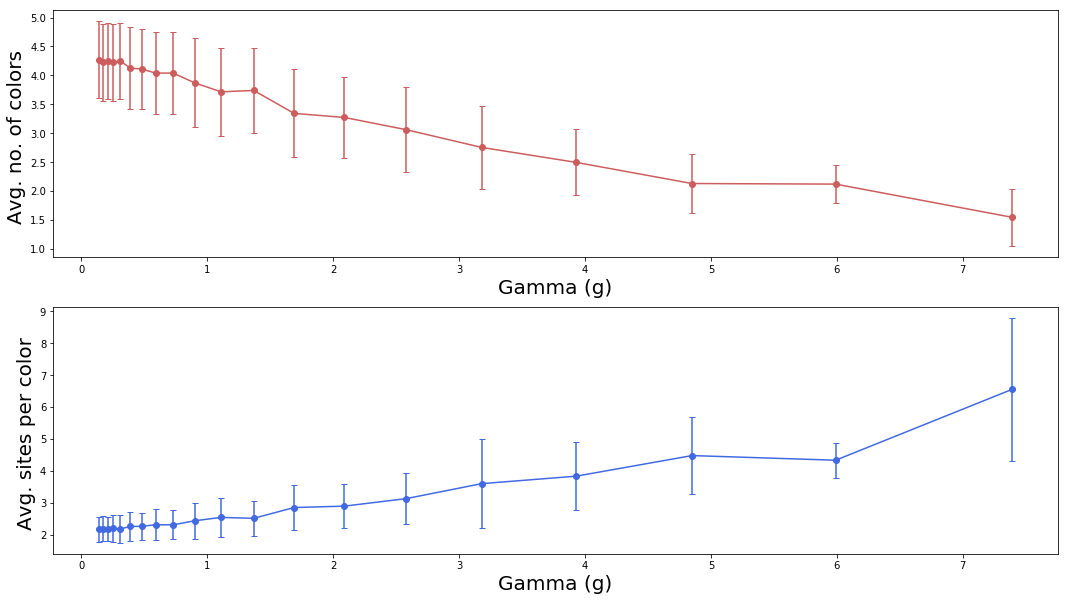

In [38]:
ngamma = 20
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 9, gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [0.14 0.18 0.24 0.32 0.42 0.56 0.75 1.   1.33 1.77 2.36 3.14 4.17 5.55
 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.0490313  0.04262577 0.03705706 0.03221586 0.02800713
 0.02434823 0.02116733 0.01840199 0.12245643]
Initial configuration
[[12  6 10  1]
 [15  9 10  9]
 [ 2 12  4 10]
 [11  4  3  5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
101 num. cols: 7.425742574257426 avg. sites per col: 2.188150243595787
201 num. cols: 7.373134328358209 avg. sites per col: 2.2140409065782185
301 num. cols: 7.4352159468438535 avg. sites per col: 2.1903918156409885
401 num. cols: 7.451371571072319 avg. sites per col: 2.185393658710374
501 num. cols: 7.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols: 7.0 avg. sites per col: 2.340782649693539
201 num. cols: 7.134328358208955 avg. sites per col: 2.2891573876648486
301 num. cols: 7.212624584717608 avg. sites per col: 2.2581448083109255
401 num. cols: 7.219451371571072 avg. sites per col: 2.259525788702855
501 num. cols: 7.217564870259481 avg. sites per col: 2.25940499952477
601 num. cols: 7.201331114808652 avg. sites per col: 2.263793148984503
701 num. cols: 7.181169757489301 avg. sites per col: 2.26804338473383
801 num. cols: 7.17103620474407 avg. sites per col: 2.2740463309751724
901 num. cols: 7.204217536071032 avg. sites per col: 2.262163733417896
1001 num. cols: 7.204795204795205 avg. sites per col: 2.2621124906839145
Final configuration:
[[ 5  3  5 12]
 [ 8  3  3 11]
 [ 1  8 12 12]
 [11  8 12 16]]
Final averages: 7.203980099502488 2.262206428176573
Fi

301 num. cols: 5.584717607973422 avg. sites per col: 2.924980224647995
401 num. cols: 5.468827930174563 avg. sites per col: 2.993278707991929
501 num. cols: 5.473053892215569 avg. sites per col: 2.9861420017108764
601 num. cols: 5.577371048252912 avg. sites per col: 2.930829569764696
701 num. cols: 5.520684736091298 avg. sites per col: 2.967760342368062
801 num. cols: 5.559300873907615 avg. sites per col: 2.945468957453972
901 num. cols: 5.568257491675916 avg. sites per col: 2.939745961277572
1001 num. cols: 5.543456543456544 avg. sites per col: 2.948695748695713
Final configuration:
[[11 11 10 11]
 [10 10  9  9]
 [11 11 11  9]
 [11  4 14 14]]
Final averages: 5.541293532338308 2.9496959646213012
Final stds: 0.8174321633624791 0.43176950262219244
------------------------------------------------------------------------------------------------------------------------

11  - gamma: 3.14
lambda probabilities: [9.56717202e-01 4.14093973e-02 1.79231457e-03 7.75763895e-05
 3.35772319e-06 1.453

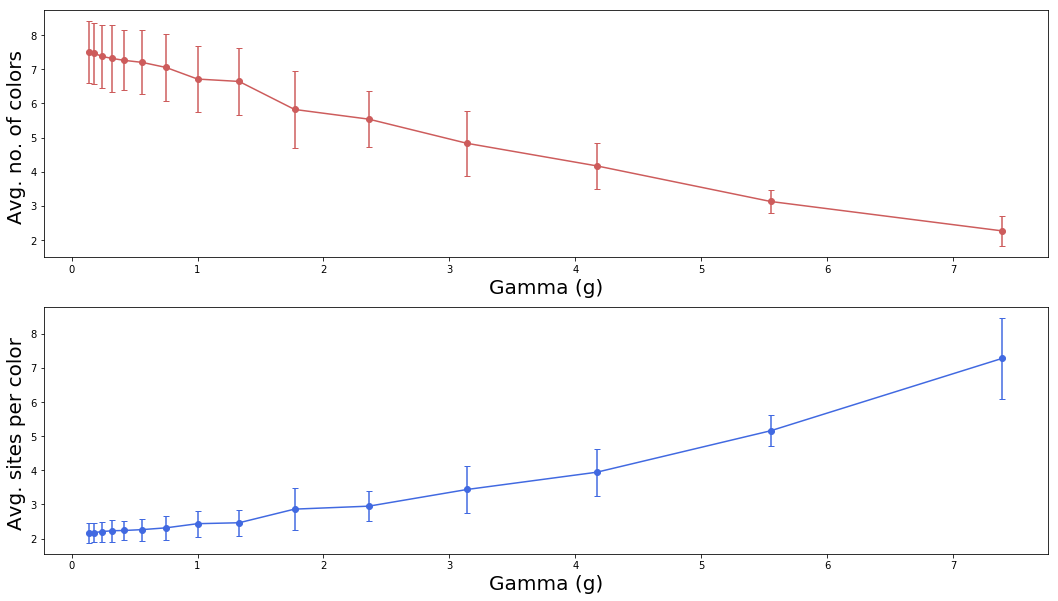

In [41]:
prt=False
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 16, gammas, J=0, alpha=0)

edge probabilities: [0.55067104 0.44932896]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [0.14 0.18 0.24 0.32 0.42 0.56 0.75 1.   1.33 1.77 2.36 3.14 4.17 5.55
 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.0490313  0.32627979]
Initial configuration
[[1 2 9]
 [9 2 7]
 [7 8 5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 1.2857142857142858
101 num. cols: 5.0 avg. sites per col: 1.8704384724186716
201 num. cols: 4.985074626865671 avg. sites per col: 1.890511727078894
301 num. cols: 5.073089700996678 avg. sites per col: 1.859124347413385
401 num. cols: 5.12219451371571 avg. sites per col: 1.8399982187388644
501 num. cols: 5.091816367265469 avg. sites per col: 1.8606073567151367
601 num. cols: 5.161397670549085 avg. sites per col: 1.8306453529831161
701 n

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 4.544554455445544 avg. sites per col: 2.1205799151343716
201 num. cols: 4.691542288557214 avg. sites per col: 2.0434968017057593
301 num. cols: 4.398671096345515 avg. sites per col: 2.196321784527765
401 num. cols: 4.448877805486284 avg. sites per col: 2.154720342002134
501 num. cols: 4.447105788423154 avg. sites per col: 2.1527801539777527
601 num. cols: 4.46089850249584 avg. sites per col: 2.1426432136914584
701 num. cols: 4.466476462196861 avg. sites per col: 2.1372630935398322
801 num. cols: 4.380774032459426 avg. sites per col: 2.208935259497048
901 num. cols: 4.399556048834628 avg. sites per col: 2.1940383700649972
1001 num. cols: 4.399600399600399 avg. sites per col: 2.1911088911088847
Final configuration:
[[6 4 3]
 [6 3 7]
 [9 3 7]]
Final averages: 4.401990049751244 2.1897014925373077
Final stds: 1.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 4.5
101 num. cols: 2.0 avg. sites per col: 4.618811881188119
201 num. cols: 1.7313432835820894 avg. sites per col: 5.798507462686567
301 num. cols: 1.8205980066445182 avg. sites per col: 5.367109634551495
401 num. cols: 1.9002493765586035 avg. sites per col: 5.165835411471321
501 num. cols: 1.7205588822355289 avg. sites per col: 5.931137724550898
601 num. cols: 1.6489184692179701 avg. sites per col: 6.224625623960066
701 num. cols: 1.5962910128388017 avg. sites per col: 6.4407988587731815
801 num. cols: 1.5767790262172285 avg. sites per col: 6.51310861423221
901 num. cols: 1.5127635960044394 avg. sites per col: 6.789123196448391
1001 num. cols: 1.4615384615384615 avg. sites per col: 7.00999000999001
Final configuration:
[[6 6 6]
 [6 6 6]
 [6 6 6]]
Final averages: 1.4597014925373135 7.017910447761194
Final stds: 0.5532517266871

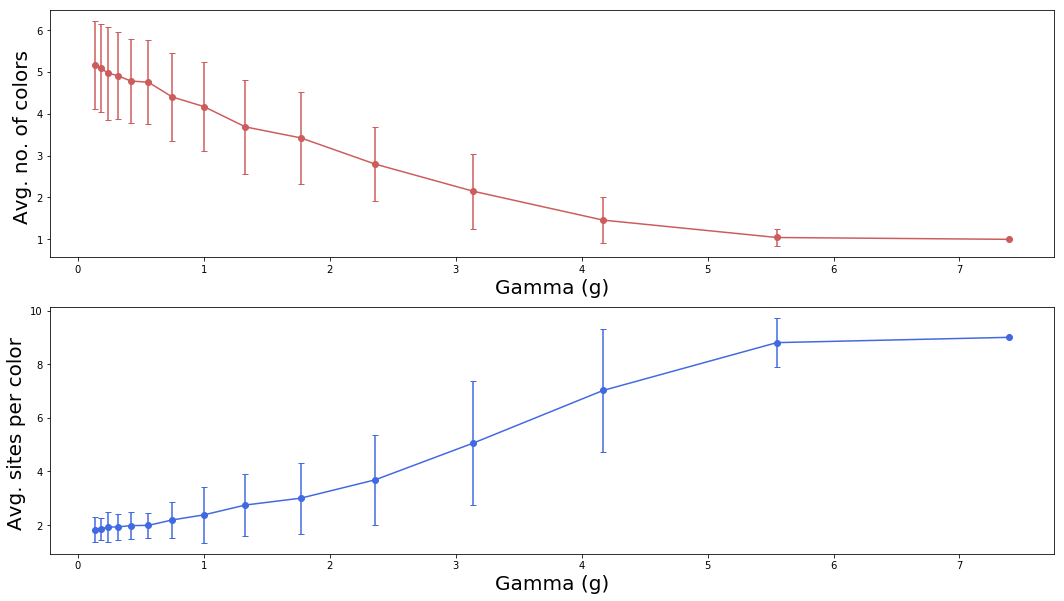

In [42]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 9, gammas, J=0.4, alpha=0)

edge probabilities: [0.69880579 0.30119421]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying gammas: [0.14 0.18 0.24 0.32 0.42 0.56 0.75 1.   1.33 1.77 2.36 3.14 4.17 5.55
 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.0490313  0.04262577 0.03705706 0.03221586 0.02800713
 0.02434823 0.02116733 0.01840199 0.01599792 0.01390793 0.01209097
 0.01051139 0.00913816 0.00794433 0.00690647 0.0060042  0.0052198
 0.03473526]
Initial configuration
[[12 23 18  2 11]
 [ 6  1  7  3 20]
 [10 20  8 19 20]
 [13 17  8  5 12]
 [ 5  5  9 18  5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 3.5714285714285716
101 num. cols: 7.663366336633663 avg. sites per col: 3.3081879616533074
201 num. cols: 7.601990049751244 avg. sites per col: 3.341

701 num. cols: 7.285306704707561 avg. sites per col: 3.5003424812626016
801 num. cols: 7.265917602996255 avg. sites per col: 3.5134405405940954
901 num. cols: 7.2552719200887905 avg. sites per col: 3.5196232581082643
1001 num. cols: 7.232767232767233 avg. sites per col: 3.5333218368932484
Final configuration:
[[17 10 10 10 14]
 [17  9  9  7 14]
 [13 13  9  8  8]
 [10  8  9  9 14]
 [ 8 14 14 14  8]]
Final averages: 7.234825870646766 3.532239595672414
Final stds: 1.0224257053266996 0.5544384060707417
------------------------------------------------------------------------------------------------------------------------

5  - gamma: 0.56
lambda probabilities: [4.28790936e-01 2.44929269e-01 1.39905819e-01 7.99154717e-02
 4.56484418e-02 2.60748037e-02 1.48941642e-02 8.50768159e-03
 4.85966484e-03 2.77588460e-03 1.58561044e-03 9.05715058e-04
 5.17352650e-04 2.95516523e-04 1.68801716e-04 9.64210704e-05
 5.50765894e-05 3.14602471e-05 1.79703783e-05 1.02648430e-05
 5.86337133e-06 3.34921085e-06

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 5.01980198019802 avg. sites per col: 5.3824846770391295
201 num. cols: 5.398009950248756 avg. sites per col: 4.90627221037668
301 num. cols: 5.528239202657807 avg. sites per col: 4.743315931023583
401 num. cols: 5.548628428927681 avg. sites per col: 4.723384989906205
501 num. cols: 5.301397205588822 avg. sites per col: 5.04496958464026
601 num. cols: 5.159733777038269 avg. sites per col: 5.189069804294446
701 num. cols: 5.075606276747504 avg. sites per col: 5.2869200461925265
801 num. cols: 5.191011235955056 avg. sites per col: 5.160810891147972
901 num. cols: 5.183129855715872 avg. sites per col: 5.169564681218408
1001 num. cols: 5.082917082917083 avg. sites per col: 5.3374403374403405
Final configuration:
[[ 1  1  1 18 20]
 [ 1  1  1 18 20]
 [ 1  1  1  1 20]
 [ 1  1  1  1  1]
 [ 1  1 18 11 18

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.2388059701492538 avg. sites per col: 22.01492537313433
301 num. cols: 1.2990033222591362 avg. sites per col: 21.262458471760798
401 num. cols: 1.2244389027431422 avg. sites per col: 22.194513715710723
501 num. cols: 1.1796407185628743 avg. sites per col: 22.75449101796407
601 num. cols: 1.1497504159733778 avg. sites per col: 23.12811980033278
701 num. cols: 1.1283880171184022 avg. sites per col: 23.39514978601997
801 num. cols: 1.1123595505617978 avg. sites per col: 23.59550561797753
901 num. cols: 1.099889012208657 avg. sites per col: 23.751387347391788
1001 num. cols: 1.08991008991009 avg. sites per col: 23.876123876123877
Final configuration:
[[21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]]
Final averages: 1.089552238

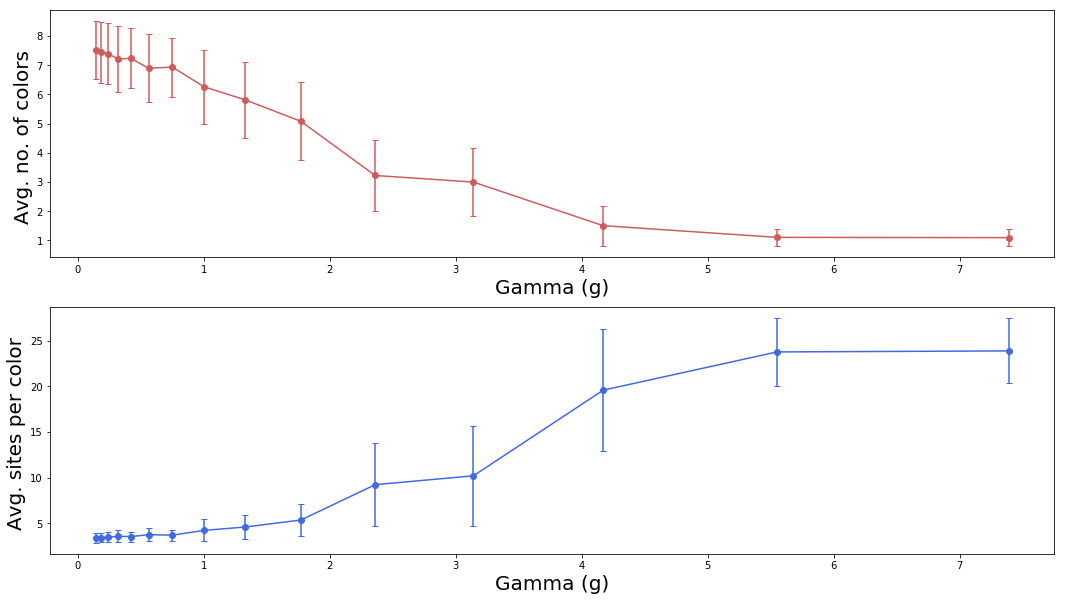

In [43]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 25, gammas, J=0.6, alpha=0)

In [175]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 5, gammas, J=0.4, alpha=0.5)

In [176]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 10, gammas, J=0.4, alpha=0.5)

In [177]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 16, gammas, J=0.4, alpha=0.5)

In [ ]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 10, gammas, J=0.4, alpha=0.5)

edge probabilities: [0.55067104 0.44932896]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.01188174 0.00720664 0.00437105 0.00265118 0.00160802
 0.00097531 0.00059156 0.00091188]
Trying gammas: [0.14 0.18 0.24 0.32 0.42 0.56 0.75 1.   1.33 1.77 2.36 3.14 4.17 5.55
 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.0490313  0.04262577 0.03705706 0.03221586 0.02800713
 0.02434823 0.02116733 0.14085842]
Initial configuration
[[13  6 13  8  5]
 [13  4 14  3 10]
 [ 8 10  4  4 14]
 [14  1 12  8  2]
 [ 5  7 12  5  3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 3.9702970297029703 avg. sites per col: 7.3125884016973135
201 num. cols: 3.9303482587064678 avg. sites per col: 7.17691305377872
301 num. cols: 4.006

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 3.386138613861386 avg. sites per col: 8.193658651579447
201 num. cols: 3.199004975124378 avg. sites per col: 9.24988154465766
301 num. cols: 3.179401993355482 avg. sites per col: 9.118414807783592
401 num. cols: 3.1496259351620948 avg. sites per col: 9.157463484146797
501 num. cols: 3.1497005988023954 avg. sites per col: 9.022074897823416
601 num. cols: 3.091514143094842 avg. sites per col: 9.272838919261543
701 num. cols: 3.094151212553495 avg. sites per col: 9.225001698254179
801 num. cols: 3.101123595505618 avg. sites per col: 9.25777302181794
901 num. cols: 3.178690344062153 avg. sites per col: 9.00698958828811
1001 num. cols: 3.144855144855145 avg. sites per col: 9.144902716331268
Final configuration:
[[1 1 1 2 3]
 [1 1 1 2 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [2 1 1 1 1]]
Final averages: 3.144278606965174 9.

101 num. cols: 1.3762376237623761 avg. sites per col: 20.627062706270625
201 num. cols: 1.6517412935323383 avg. sites per col: 18.138474295190733
301 num. cols: 1.6345514950166113 avg. sites per col: 18.313953488372103
401 num. cols: 1.6134663341645885 avg. sites per col: 18.635702410640064
501 num. cols: 1.5848303393213572 avg. sites per col: 18.987025948103806
601 num. cols: 1.6272878535773712 avg. sites per col: 18.462285080421548
701 num. cols: 1.5777460770328102 avg. sites per col: 18.89562529719451
801 num. cols: 1.5905118601747816 avg. sites per col: 18.76300457761135
901 num. cols: 1.5993340732519423 avg. sites per col: 18.59970403255645
1001 num. cols: 1.5764235764235763 avg. sites per col: 18.785381285381312
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [2 1 1 1 1]
 [1 2 2 1 1]
 [1 1 1 1 2]]
Final averages: 1.5781094527363184 18.760364842454422
Final stds: 0.7018939608649625 6.853774311299493
----------------------------------------------------------------------------------

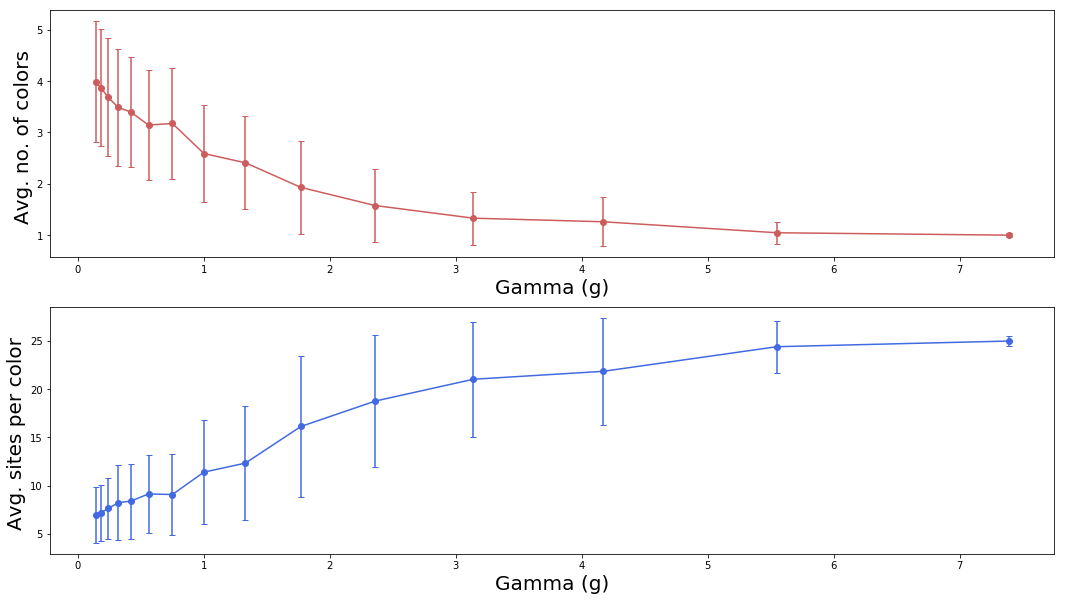

In [9]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 15, gammas, J=0.4, alpha=0.5)

In [ ]:
ngamma = 10
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (8, 8, gammas, J=0.4, alpha=0.5)

In [158]:
nalpha = 10
alphas = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_alpha (5, 5, alphas, J=0.4, gamma=0.5)

In [ ]:
nalpha = 10
alphas = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_alpha (8, 8, alphas, J=0.4, gamma=0.5)

In [170]:
nalpha = 10
alphas = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_alpha (8, 4, alphas, J=0.4, gamma=0.5)

In [163]:
nJ = 10
Js = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (5, 5, Js, alpha=0.5, gamma=0.5)

In [10]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (8, 8, Js, alpha=0.5, gamma=0.5)

lambda probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.03019738]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.03019738]
Trying Js: [0.14 0.16 0.19 0.22 0.25 0.3  0.35 0.41 0.48 0.56 0.66 0.77 0.9  1.05
 1.23 1.45 1.69 1.98 2.32 2.72]
0  - J: 0.14
edge probabilities: [0.24421626 0.75578374]
Initial configuration
[[7 6 6 7 2 3 6 1]
 [3 8 2 8 4 2 1 7]
 [8 2 4 1 4 5 3 7]
 [1 3 4 2 3 4 5 5]
 [5 7 5 8 6 2 5 6]
 [3 6 6 7 6 6 5 8]
 [4 2 2 6 8 8 2 5]
 [3 2 1 3 4 6 4 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 12.8
101 num. cols: 6.603960396039604 avg. sites per col: 9.916831683168308
201 num. cols: 6.472636815920398 avg. sites per col: 10.104904051172712
301 num. cols: 6.48172757475083 avg. sites per col: 10.084480303749425
401 num. cols: 6.4937655860

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 12.8
101 num. cols: 5.603960396039604 avg. sites per col: 11.835172088637426
201 num. cols: 5.477611940298507 avg. sites per col: 12.21966358682777
301 num. cols: 5.428571428571429 avg. sites per col: 12.286157253599136
401 num. cols: 5.55860349127182 avg. sites per col: 11.971214820092657
501 num. cols: 5.512974051896207 avg. sites per col: 12.060906757912795
601 num. cols: 5.447587354409317 avg. sites per col: 12.202139291656827
701 num. cols: 5.445078459343795 avg. sites per col: 12.206779430745236
801 num. cols: 5.466916354556804 avg. sites per col: 12.174496165507387
901 num. cols: 5.452830188679245 avg. sites per col: 12.194281486179309
1001 num. cols: 5.5054945054945055 avg. sites per col: 12.067094809951838
Final configuration:
[[2 2 1 2 2 1 1 1]
 [2 5 1 1 1 1 1 1]
 [1 1 5 1 1 2 1 1]
 [1 1 1 1 1 1 2 2]
 [5 3 2 3 1 1 3 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [167]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (8, 5, Js, alpha=0.5, gamma=0.5)

In [168]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (15, 5, Js, alpha=0.5, gamma=0.5)

In [171]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (15, 15, Js, alpha=0.5, gamma=0.5)